## 학습목표

Classification model로부터 CAM을 얻어낼 수 있다.

CAM으로 물체의 위치를 찾을 수 있다.

CAM을 시각화 비교할 수 있다.

## 학습 내용

CAM, Grad-CAM용 모델 준비하기

CAM

Grad-CAM

Detection with CAM

In [1]:
! mkdir -p ~/aiffel/class_activation_map

## CAM, Grad-CAM용 모델 준비하기

CAM은 특성 추출하는 CNN네트워크 뒤에 GAP와 softmax layer가 붙어야 하는 구성적 제약이 있으나 Grad-CAM은 없습니다.

이 파트에선 CAM, Grad-CAM을 구현할 것이고,  CAM모델을 먼저 구현한 후에 이 모델을 활용하여 Grad-CAM이용하여 시각화 결과물을 추출합니다.

CAM은 클래스에 대한 활성화 정도를 나타낸 것으로 기본 모델은 Classification을 수행합니다.

허나, 최종 목표는 위치를 확인하고 정답과 비교하는 것으로 위치 정보가 기록된 데이터도 함께 있어야 합니다.



### Tensorflow Datasets

- Standford_dogs데이터셋 사용

   - 120종개의 개 사진 판별
   
   - 분류문제 데이터셋
   
   - 바운딩 박스: 라벨이 위치 정보

필요한 라이브러리 불러오기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


GPU확인|

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Stanford_dogs데이터셋

- 학습용 데이터셋: 12000장

- 평가용 데이터셋: 8580장




데이터 다운로드하기

In [6]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


학습 데이터 확인하기

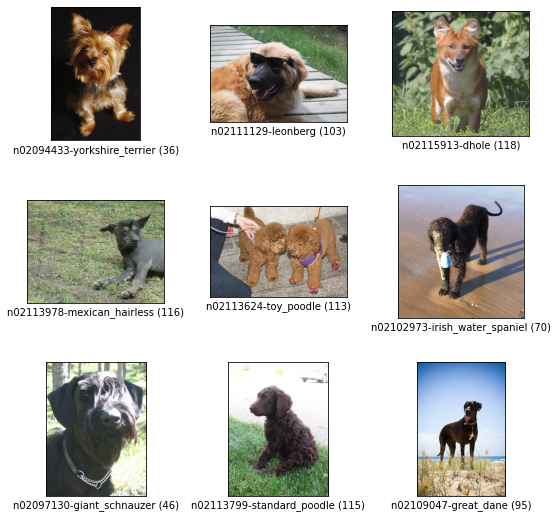

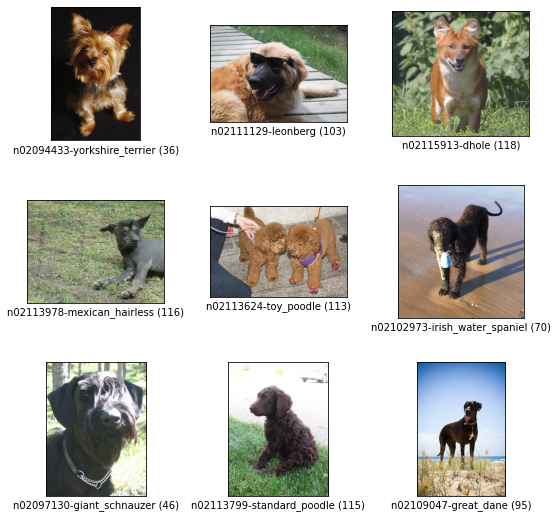

In [7]:
tfds.show_examples(ds_train, ds_info)

평가데이터 확인하기

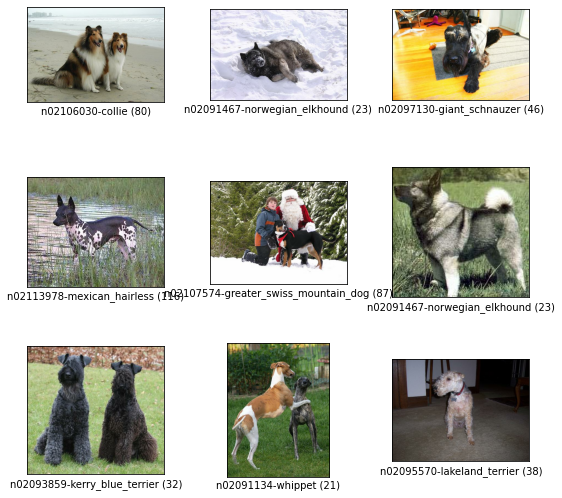

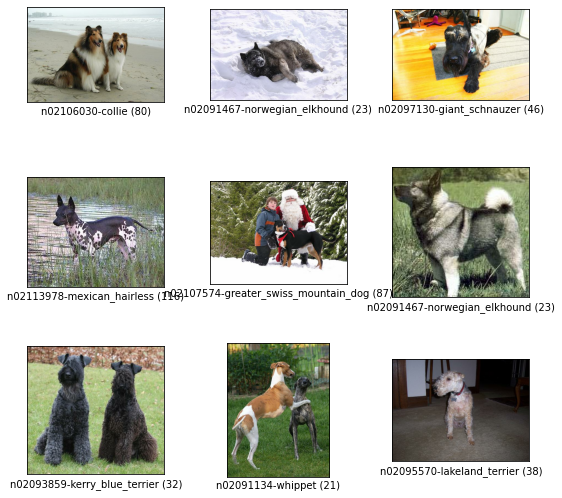

In [8]:
tfds.show_examples(ds_test, ds_info)

### 물체의 위치 정보

Features 확인하기

- image: 입력이미지

- label: 해당 이미지의 정답 클래스 인덱스

- bbox: 바운딩 박스, 물체의 위치를 사각형 영역으로 표기

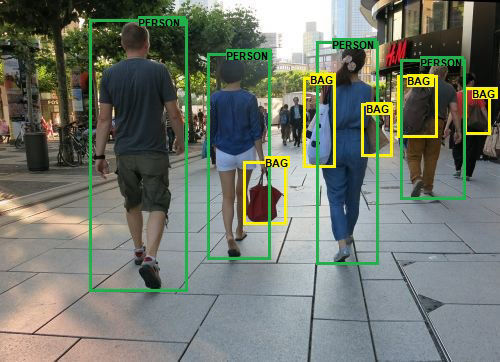


In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

### 바운딩 박스 표시하는 방법들

####   xywh

바운딩 박스 중심적을 x,y로 표기하고, 사각형읜 너비 w와h를 표기하는 방식입니다.

ex:(x_center, y_center, width, height)

x,y가 중심점이 아니라 좌측 상단의 점을 가리키게 될 수도 있습니다.


#### minmax

바운딩박스를 이루는 좌표의 최솟값과 최댓값 표기

ex: (x_min, x_max, y_min, y_max)


좌표의 절댓값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값 표기 하는것이다.


###  BBoxFeature

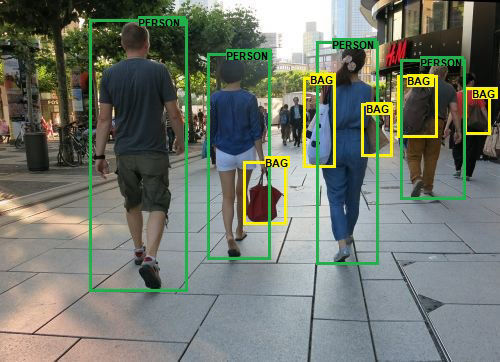

이 바운딩 박스는 minmax를 의미하고, tfds의 경우 height를 첫번째 axis로 삼고 있기에([ymin, xmin, ymax, xmax)를 의미합니다.



### CAM을 위한 모델 만들기


- 이미지 데이터: ImageNet

- 훈련 모델: ResNet50

- pooling layer + Softmax layer(활성활 함수, fc layer) 과정을 거치면  Grad-CAM모델이 만들어집니다.

구현 해보기

CAM모델구조

- 분류 모델과 유사하다

- FC layer 대신 pooling='avg'(GAP연산 가능)



In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [11]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### CAM 모델 학습하기

- normalize_and_resize_img()


   - 힉습 데이터와 검증 데이터 간단한 전처리(normalizing, resizing)
   
   
- apply_normalize_on_dataset()


   - 배치 구성
   
   
- input

  
   - bbox 정보 포함
   
   
- 활용도(object detection, segmentation)


   - 직접적인 라벨(bounding box) 사용 안합니다
   
   - 약지도학습으로 물체 영역을 간접적으로 학습시킵니다.

In [12]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [13]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [14]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [16]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=3,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 663s 877ms/step - loss: 2.1878 - accuracy: 0.4438 - val_loss: 3.0749 - val_accuracy: 0.2519
Epoch 2/3
750/750 [==============================] - 331s 442ms/step - loss: 0.7269 - accuracy: 0.8002 - val_loss: 1.1623 - val_accuracy: 0.6599
Epoch 3/3
750/750 [==============================] - 332s 442ms/step - loss: 0.2186 - accuracy: 0.9559 - val_loss: 0.9577 - val_accuracy: 0.7180


학습시킨 가중치 저장

In [17]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


### CAM

메모리 부족 현상이 일어날 수도 있으니 커널을 재시작 후에 하겠습니다.


In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


CAM생성이 배치 단위로 이뤄지지 않고 개별 이미지 데이터 단위로 이뤄지므로 get_one()함수를 통해서 한 장씩 뽑는 것으로 만들었습니다.


In [3]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


데이터는 준비가 되었고, CAM 생성을 위해 이전 스텝에서 학습한 모델을 불러와서 이용하겠습니다.

67


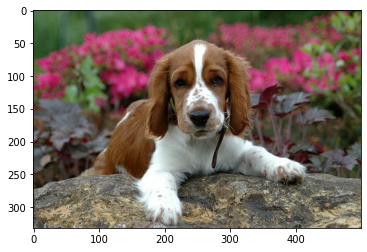

In [4]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [5]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


#### CAM 생성 조건

1. 특성맵

2. 소프트맥스 레이어의 가중치(클래스별 확률 얻음)

3. 원하는 클래스의 출력값


모델이 입력 이미지를 어떻게 보고 있는지 직관적으로 알기 위해서 CAM을 입력 사이즈와 같게 하여 시각화를 진행할 것입니다.

고로, model과 item을 받았을 시, 입력이미지와 동일 크기의 CAM을 반환하는 함수를 만들어야합니다.


generate_cam()을 구현하기 위해 레이어의 결과값을 output으로 받아 새로운 모델을 정의하고나서, feedforward를 거친 후에 CAM을 게산하도록 구현했습니다.

마지막으로, 입력 이미지의 크기에 CAM을 resize했습니다.



In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


정확한 위치 표현이 가능해집니다.

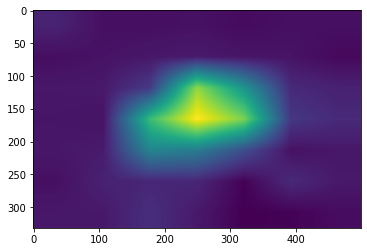

In [8]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

CAM이미지와 원본 이미지를 합쳐보겠습니다.

In [9]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


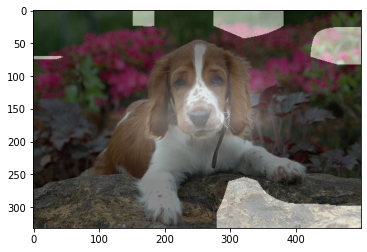

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

   
Grad-CAM은 적용 모델을 유연하게 선택할 수 있고, 만들었던 모델을 다시 활용해도 되기에 관찰 모델은 그대로 cam_model을 사용합니다.

새로운 이미지를 뽑겠습니다.

100


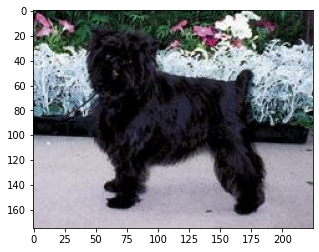

In [11]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### Grad-CAM을 이용하여 CAM 만들기

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고 GAP연산을 적용하여 레이어별 가중치를 구합니다.


그리고, 채널별 가중치와 특성맵을 가중합하여 cam_image를 얻게 되는데 이것이 최종 CAM의 이미지입니다.


Grad-CAM은 CAM과 달리 어떤 레이어든 CAM이미지를 뽑아낼 수 있기에 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer을 뽑아서 쓸 수 있게 activation_layer의 이름을 받고 활용합니다.


그리고, generate_grad_cam()에선 원하는 레이어의 output와 특정 클래스의 prediction사이의 그래디언트를 얻어서 가중치로 사용합니다.

In [12]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


여러 레이어의 CAM이미지 뽑기입니다.


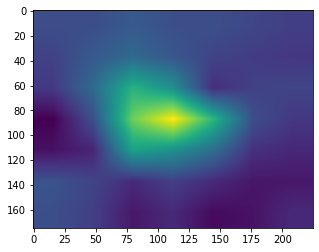

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

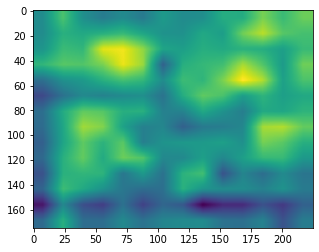

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

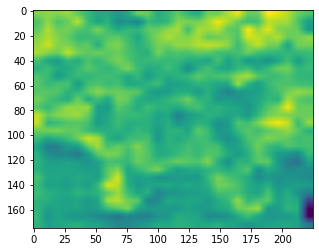

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### Detection with CAM


#### 바운딩 박스

CAM에서 물체의 위치를 찾는 detection을 하겠습니다.



새로운 이미지 뽑겠습니다

116


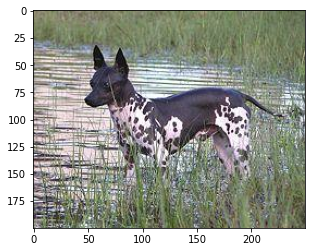

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

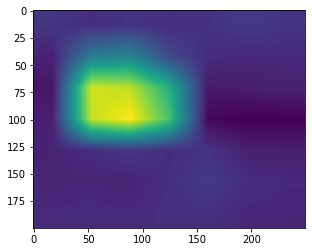

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()


- generate_cam(): CAM이미지 뽑기

- get_bbox(): 바운딩 박스 만드는 함수

   - score_thresh: 역치값 이하의 바운딩 박스 없애기
   
 
- OpenCV활용

   - findContours() 와  minAreaReac(): 사각형 찾기
   
   
- rotated_rect(): 회전된 바운딩 박스 얻기

- boxPoints(): 꼭지점으로 바꿔준다.

- int자료형으로 변환해준다.

In [18]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


cam_image를 통해 bbox를 얻고 이미지 위에 시각화한다.

In [19]:
rect = get_bbox(cam_image)
rect

array([[144, 155],
       [160, 139],
       [175, 154],
       [159, 170]])

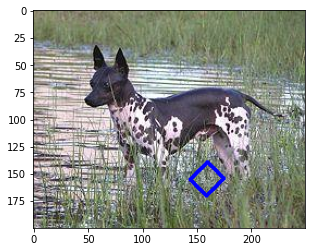

In [20]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()


### Intersection Over Union(IOU)
CAM과 Grad-CAM 두 가지 방법을 이용해서 바운딩 박스를 얻을 수 있습니다.

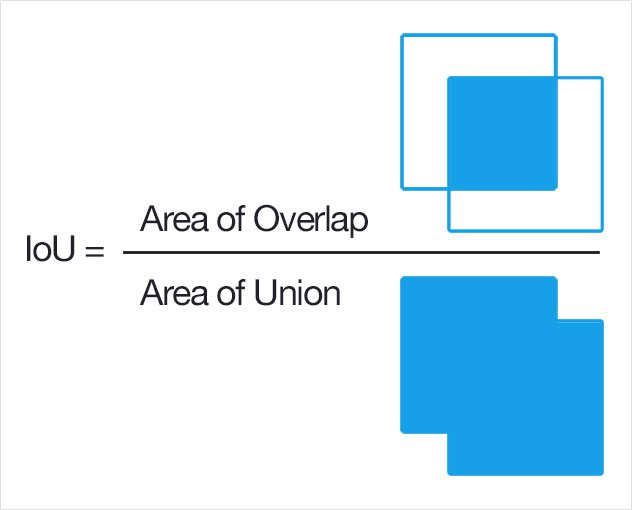

IOU는 두 영역의 교집합인 영역의 넓이를 합집합으로 나눠줍니다. 이를 통해서 면적과 상관없이 영여깅 잘 찾아내었는지에 대한 상대적인 비율도 구할 수 있게 됩니다.




In [21]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


rect를 minmax bbox형태로 치환합니다.

In [22]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.695, 0.576, 0.85, 0.7]

데이터의 ground truth bbox를 확인합니다.

In [23]:
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

둘이 얼마나 유사한지 IoU를 계산하여 확인합니다.

In [24]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [25]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.027642141706944484